# Project : Wrangle and Analyze Data 
** by Saravanan Natarajan **

### Introduction:

Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. 
Wrangling involves `Wow`- worthy analyses and visualizations.

#### Import libraries

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import requests
import sqlalchemy
import tweepy
import json
import re
import time
from PIL import Image
from io import BytesIO

##### Create functions for Programmatic assessment

In [3]:
def get_df_list(df):
    return list(df)

def get_df_info(df):
    df.info()

def get_df_describe(df):
    return df.describe()

def get_df_sample(df, sample_value):
    return df.sample(sample_value)

def get_df_value_counts(df):
    return df.value_counts()

def get_df_len(df):
    return len(df)

def get_df_head(df, count):
    return df.head(count)

### Gathering Data

#### Data from WeRateDogs Twitter archive

In [4]:
df_weratedogs_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### Data from Neural Network based image prediction

In [5]:
udacity_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
url_response = requests.get(udacity_url)

with open(udacity_url.split('/')[-1], mode='wb') as file:
    file.write(url_response.content)
    
df_nn_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

#### Data from Query Twitter API

##### Access my Twitter account

In [144]:
access_token = "YOUR ACCESS TOKEN"
access_token_secret = "YOUR ACCESS SECRET"
consumer_key = "YOUR CONSUMER KEY"
consumer_secret = "YOUR CONSUMER SECRET"

##### Tweepy to query JSON data from Twitter

In [8]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify = True)

##### Extract JSON data from Twitter API


[Twitter Data Dictionary](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)

[JSON object and array](https://github.com/anoru/Wrangling-Data-WeRateDogs/blob/master/wrangle_act.ipynb)


In [9]:
get_df_head(df_weratedogs_archive, 2)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   

   rating_denominator     name doggo floofer pupper puppo  
0                  10  Phineas  None    None   None  None  
1                  10    Tilly  None    None   None  None

** Interested in additional data such as date and time of the creation of the tweet and utility used to post the tweet. **

In [10]:
df_list = []
error_list = []

start = time.time()
 
for tweet_id in df_weratedogs_archive.tweet_id:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        
        favorites = page['favorite_count']
        retweets = page['retweet_count'] 
        date_time = page['created_at']
        source = page['source'] 
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'date_time': pd.to_datetime(date_time),
                        'utility_source' : str(source)})
    
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 209
Rate limit reached. Sleeping for: 200


2221.381744861603


** The tweets corresponding to a few tweet IDs in the archive may have been deleted were captured in error_list **

In [11]:
error_list

[888202515573088257,
 873697596434513921,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 845459076796616705,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 802247111496568832,
 775096608509886464]

In [13]:
print("The lengh of the result", len(df_list))
print("The lengh of the errors", len(error_list))

The lengh of the result 2345
The lengh of the errors 11


From the above results:

* We reached the limit of the Tweepy API twice but wait_on_rate_limit automatically wait for rate limits to replenish and wait_on_rate_limit_notify print a notification when Tweepy is waiting
* The total time was about 2221.381744861603 seconds (~ 37 min)
* We could get 2345 tweet_id correctly with 11 were deleted (we will query those 11 errors separately)

In [14]:
ee_list = []
for e in error_list:
    try:
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        date_time = page['created_at']
        source = page['source']
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'date_time': pd.to_datetime(date_time),
                        'utility_source' : str(source)})
        
    except Exception:
        print(str(tweet_id)+ " _ " + str(e))
        ee_list.append(e)

In [15]:
print("The lengh of the result after Querying the errors separately", len(df_list))
print("The lengh of the errors", len(ee_list))

The lengh of the result after Querying the errors separately 2356
The lengh of the errors 0


** During cleaning we can remove the error list **

##### Write JSON data in text file

In [16]:
df_json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'date_time', 'utility_source'])

df_json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [17]:
df_json_tweets = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
get_df_head(df_json_tweets, 5)

tweet_id  favorites  retweets            date_time  \
0  892420643555336193      38785      8583  2017-08-01 16:23:56   
1  892177421306343426      33225      6308  2017-08-01 00:17:27   
2  891815181378084864      25021      4187  2017-07-31 00:18:03   
3  891689557279858688      42152      8698  2017-07-30 15:58:51   
4  891327558926688256      40329      9470  2017-07-29 16:00:24   

                                      utility_source  
0  <a href="http://twitter.com/download/iphone" r...  
1  <a href="http://twitter.com/download/iphone" r...  
2  <a href="http://twitter.com/download/iphone" r...  
3  <a href="http://twitter.com/download/iphone" r...  
4  <a href="http://twitter.com/download/iphone" r...

**The file tweet_json.txt successfully saved in our working directory contains the result of the API Querying then stored in df_json_tweets data frame, it has 6 columns and 2356 entries**


### Gather: Summary
Gathering is the first step in the data wrangling process. We could finish the high-level gathering process:

* Obtaining data

    * Getting data from an existing file (twitter-archive-enhanced.csv) Reading from csv file using pandas
    * Downloading a file from the internet (image-predictions.tsv) Downloading file using requests
    * Querying an API (tweet_json.txt) Get JSON object of all the tweet_ids using Tweepy
* Importing that data into our programming environment (Jupyter Notebook)

### Assessing Data

[Plot data reference](https://github.com/MrGeislinger/UdacityDAND_Proj_WrangleAndAnalyzeData/blob/master/wrangle_act.ipynb)

#### Assess WeRateDogs Twitter archive

##### Programmatic assessment of WeRateDogs archive

In [18]:
get_df_list(df_weratedogs_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [19]:
get_df_info(df_weratedogs_archive)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
get_df_describe(df_weratedogs_archive)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [21]:
get_df_sample(df_weratedogs_archive, 7)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2198  668815180734689280                    NaN                  NaN   
801   772581559778025472                    NaN                  NaN   
778   775898661951791106                    NaN                  NaN   
1425  697943111201378304                    NaN                  NaN   
774   776218204058357768                    NaN                  NaN   
1439  696894894812565505                    NaN                  NaN   
1198  716802964044845056                    NaN                  NaN   

                      timestamp  \
2198  2015-11-23 15:35:39 +0000   
801   2016-09-04 23:46:12 +0000   
778   2016-09-14 03:27:11 +0000   
1425  2016-02-12 00:39:39 +0000   
774   2016-09-15 00:36:55 +0000   
1439  2016-02-09 03:14:25 +0000   
1198  2016-04-04 01:41:58 +0000   

                                                 source  \
2198  <a href="http://twitter.com/download/iphone" r...   
801   <a href="http://twitter.com/download/iphone" r...   
778   <a href="http://twitter.com/download/iphone" r...   
1425  <a href="http://twitter.com/download/iphone" r...   
774   <a href="http://twitter.com/download/iphone" r...   
1439  <a href="http://twitter.com/download/iphone" r...   
1198  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
2198  This is a wild Toblerone from Papua New Guinea...                  NaN   
801   Guys this is getting so out of hand. We only r...                  NaN   
778   RT @dog_rates: Like father (doggo), like son (...         7.331095e+17   
1425  This is Cassie. She goes door to door trying t...                  NaN   
774   Atlas rolled around in some chalk and now he's...                  NaN   
1439  These two pirates crashed their ship and don't...                  NaN   
1198  This is Link. He struggles with couches. 10/10...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
2198                       NaN                        NaN   
801                        NaN                        NaN   
778               4.196984e+09  2016-05-19 01:38:16 +0000   
1425                       NaN                        NaN   
774                        NaN                        NaN   
1439                       NaN                        NaN   
1198                       NaN                        NaN   

                                          expanded_urls  rating_numerator  \
2198  https://twitter.com/dog_rates/status/668815180...                 7   
801   https://twitter.com/dog_rates/status/772581559...                10   
778   https://twitter.com/dog_rates/status/733109485...                12   
1425  https://twitter.com/dog_rates/status/697943111...                10   
774   https://twitter.com/dog_rates/status/776218204...                13   
1439  https://twitter.com/dog_rates/status/696894894...                 9   
1198  https://twitter.com/dog_rates/status/716802964...                10   

      rating_denominator    name  doggo  floofer  pupper puppo  
2198                  10       a   None     None    None  None  
801                   10       a   None     None    None  None  
778                   10    None  doggo     None  pupper  None  
1425                  10  Cassie   None     None    None  None  
774                   10    None   None  floofer    None  None  
1439                  10    None   None     None    None  None  
1198                  10    Link   None     None    None  None

**WeRateDogs is popular because of the rating system, we will view rating numerators and denominators**

In [146]:
get_df_value_counts(df_weratedogs_archive.rating_numerator)

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [147]:
get_df_value_counts(df_weratedogs_archive.rating_denominator)

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [22]:
get_df_value_counts(df_weratedogs_archive.name)

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Penny          10
Tucker         10
Winston         9
Bo              9
the             8
Sadie           8
Toby            7
Daisy           7
Bailey          7
an              7
Buddy           7
Bella           6
Rusty           6
Jack            6
Koda            6
Stanley         6
Scout           6
Oscar           6
Leo             6
Milo            6
Jax             6
Dave            6
Chester         5
             ... 
Autumn          1
Patch           1
Shnuggles       1
Rover           1
Mo              1
Caryl           1
Rodman          1
Jeffri          1
Tiger           1
Petrick         1
Chase           1
Jessiga         1
Tino            1
Ozzie           1
Bruno           1
Lambeau         1
Pluto           1
Longfellow      1
Grizzwald       1
Kaiya           1
Olaf            1
Harlso          1
Crawford        1
Ambrose         1
Freddery  

** Randomly assess the data **

In [148]:
print(df_weratedogs_archive.text[800])
print(df_weratedogs_archive.name[220])

RT @dog_rates: This is Gromit. He's pupset because there's no need to beware of him. Just wants a pettin. 10/10 https://t.co/eSvz4EapHH
Boomer


In [149]:
print(df_weratedogs_archive[df_weratedogs_archive.rating_numerator == 0])

                tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
315   835152434251116546                    NaN                  NaN   
1016  746906459439529985           7.468859e+17         4.196984e+09   

                      timestamp  \
315   2017-02-24 15:40:31 +0000   
1016  2016-06-26 03:22:31 +0000   

                                                 source  \
315   <a href="http://twitter.com/download/iphone" r...   
1016  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
315   When you're so blinded by your systematic plag...                  NaN   
1016  PUPDATE: can't see any. Even if I could, I cou...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
315                        NaN                        NaN   
1016                       NaN                        NaN   

                                          expanded_urls  rating_numerator 

##### Programmatic assessment image prediction data frame

In [26]:
get_df_list(df_nn_image_predictions)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [27]:
get_df_info(df_nn_image_predictions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
get_df_describe(df_nn_image_predictions)

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [29]:
get_df_sample(df_nn_image_predictions, 3)

tweet_id                                          jpg_url  \
1684  814153002265309185  https://pbs.twimg.com/media/C0xz04SVIAAeyDb.jpg   
1948  862831371563274240  https://pbs.twimg.com/media/C_lkieeVwAAm0L4.jpg   
1863  842846295480000512  https://pbs.twimg.com/media/C7JkO0rX0AErh7X.jpg   

      img_num                  p1   p1_conf  p1_dog                  p2  \
1684        1    golden_retriever  0.490068    True  Labrador_retriever   
1948        2  Australian_terrier  0.207281    True       Irish_terrier   
1863        1  Labrador_retriever  0.461076    True    golden_retriever   

       p2_conf  p2_dog               p3   p3_conf  p3_dog  
1684  0.291956    True             chow  0.072475    True  
1948  0.156296    True  German_shepherd  0.123536    True  
1863  0.154946    True        Chihuahua  0.110249    True

In [30]:
get_df_value_counts(df_nn_image_predictions.p1_conf)

0.366248    2
0.713293    2
0.375098    2
0.636169    2
0.611525    2
0.420463    2
0.581403    2
0.403698    2
0.530104    2
0.254856    2
0.346545    2
0.721188    2
0.677408    2
0.907083    2
0.243529    2
0.505370    2
0.593858    2
0.372202    2
0.274637    2
0.600276    2
0.506312    2
0.615163    2
0.556595    2
0.995143    2
0.809197    2
0.964929    2
0.777468    2
0.336200    2
0.617389    2
0.786089    2
           ..
0.483228    1
0.556524    1
0.176423    1
0.318981    1
0.733025    1
0.730152    1
0.436023    1
0.479008    1
0.162935    1
0.897162    1
0.320420    1
0.999833    1
0.995873    1
0.523206    1
0.942911    1
0.537652    1
0.672791    1
0.952258    1
0.855959    1
0.665578    1
0.841265    1
0.668164    1
0.946828    1
0.714719    1
0.352946    1
0.713102    1
0.765266    1
0.491022    1
0.905334    1
1.000000    1
Name: p1_conf, Length: 2006, dtype: int64

In [240]:
df_nn_image_predictions[df_nn_image_predictions['jpg_url'] == 
                        'https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg']

tweet_id                                          jpg_url  \
800   691416866452082688  https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg   
1624  803692223237865472  https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg   

      img_num                p1   p1_conf  p1_dog             p2   p2_conf  \
800         1  Lakeland_terrier  0.530104    True  Irish_terrier  0.197314   
1624        1  Lakeland_terrier  0.530104    True  Irish_terrier  0.197314   

      p2_dog        p3   p3_conf  p3_dog  
800     True  Airedale  0.082515    True  
1624    True  Airedale  0.082515    True

In [241]:
print(df_nn_image_predictions [df_nn_image_predictions.tweet_id.isnull()])
print(df_nn_image_predictions[df_nn_image_predictions.tweet_id.duplicated()])

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []
Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []


Based on [reference](https://github.com/mccormd1/Analytics_Nanodegree/blob/master/3-Data%20Wrangling/Final_Project/wrangle_act.ipynb) we further assess the prediction data

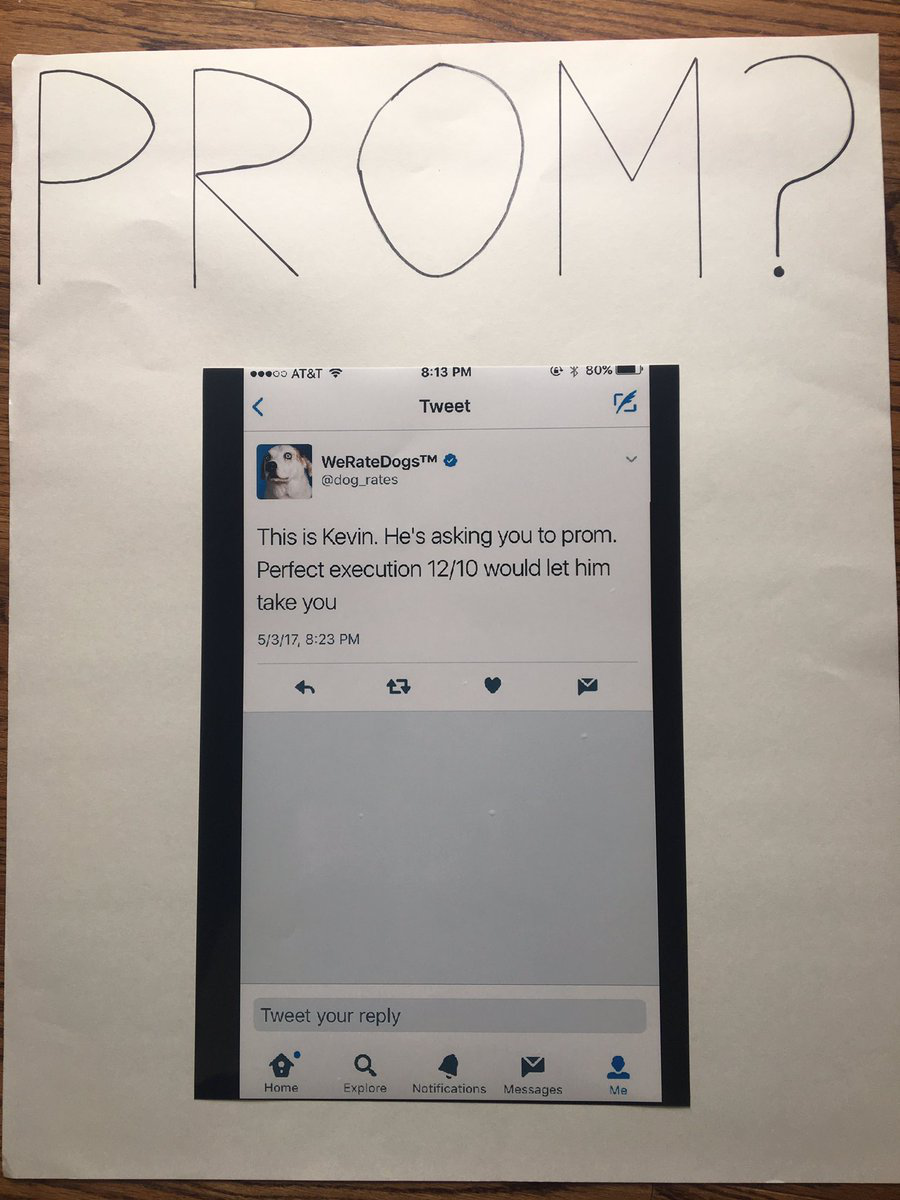

In [150]:
envelope_image_url = df_nn_image_predictions.jpg_url[df_nn_image_predictions.
                                                     tweet_id==860924035999428608].iloc[0]
request_image = requests.get(envelope_image_url)
image = Image.open(BytesIO(request_image.content))
image

At p1 it was predicted as envelope, then oscilloscope and finally paper_towel.
Same we can try for box_turtle below

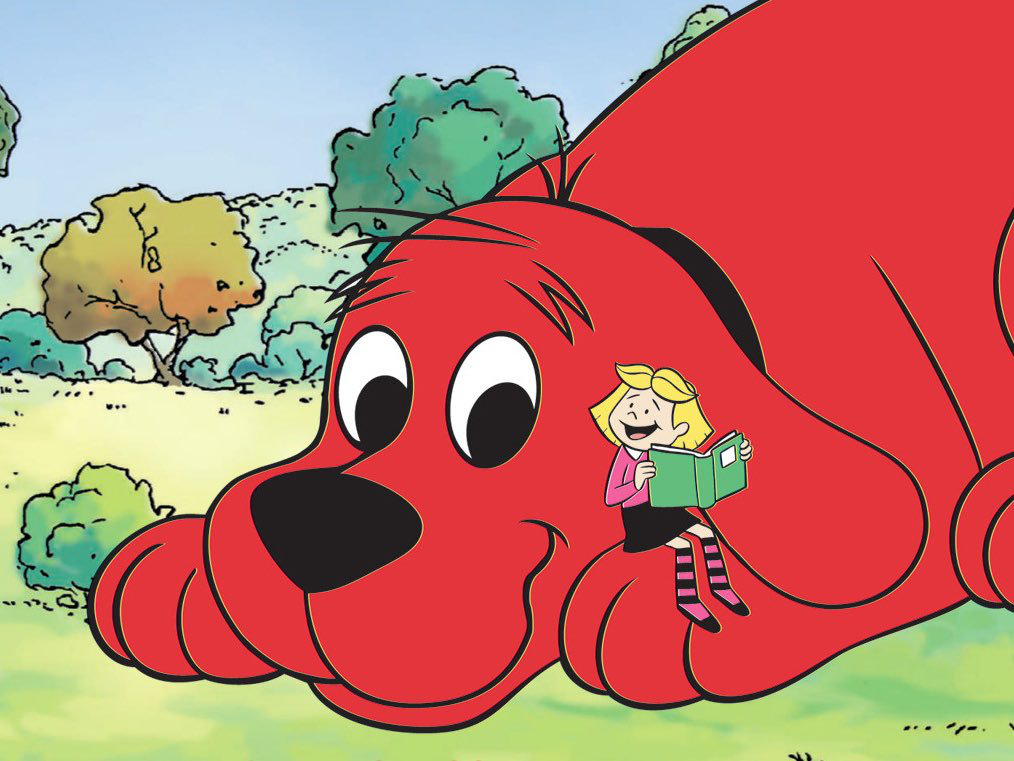

In [247]:
envelope_image_url = df_nn_image_predictions.jpg_url[df_nn_image_predictions.
                                                     tweet_id==870063196459192321].iloc[0]
request_image = requests.get(envelope_image_url)
image = Image.open(BytesIO(request_image.content))
image


Even Clifford was added in prediction

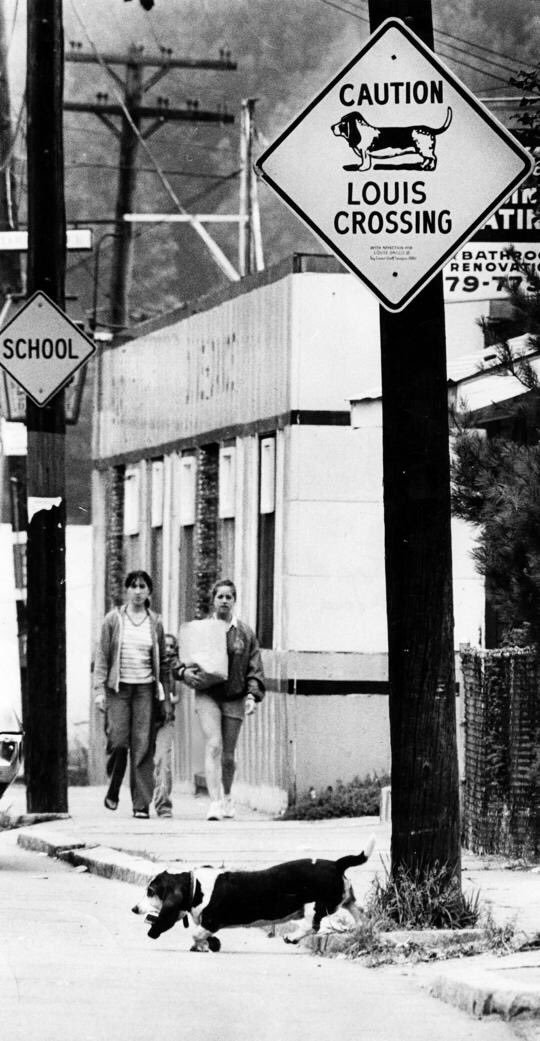

In [248]:
box_turtle_image_url = df_nn_image_predictions.jpg_url[df_nn_image_predictions.
                                                       tweet_id==880935762899988482].iloc[0]
request_image_box_turtle = requests.get(box_turtle_image_url)
image = Image.open(BytesIO(request_image_box_turtle.content))
image

Prediction involves picture and real dog

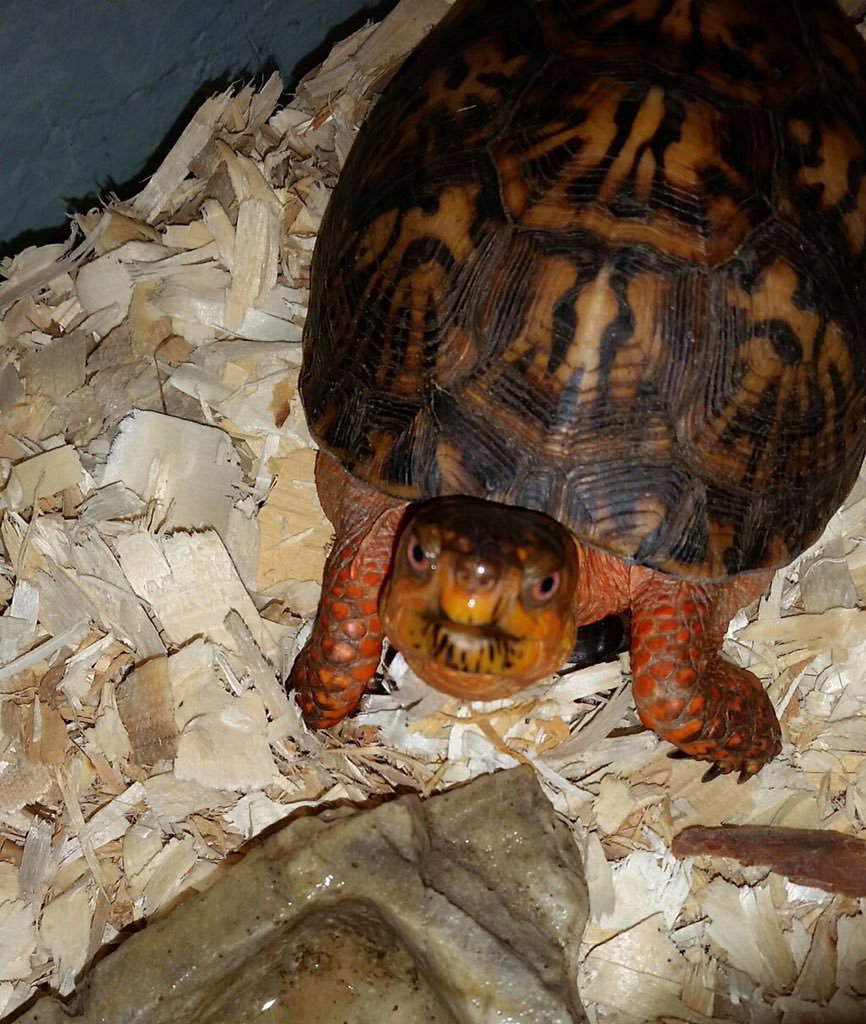

In [151]:
box_turtle_image_url = df_nn_image_predictions.jpg_url[df_nn_image_predictions.
                                                       tweet_id==666051853826850816].iloc[0]
request_image_box_turtle = requests.get(box_turtle_image_url)
image = Image.open(BytesIO(request_image_box_turtle.content))
image

It's a turtle

##### Programmatic assessment of twitter JSON

In [35]:
get_df_list(df_json_tweets)

['tweet_id', 'favorites', 'retweets', 'date_time', 'utility_source']

In [36]:
get_df_info(df_json_tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id          2356 non-null int64
favorites         2356 non-null int64
retweets          2356 non-null int64
date_time         2356 non-null object
utility_source    2356 non-null object
dtypes: int64(3), object(2)
memory usage: 92.1+ KB


In [37]:
get_df_sample(df_json_tweets, 5)

tweet_id  favorites  retweets            date_time  \
1286  707776935007539200       3502      1034  2016-03-10 03:55:45   
1866  675109292475830276       2922      1213  2015-12-11 00:26:12   
358   828801551087042563          0      3777  2017-02-07 03:04:22   
1045  742161199639494656       4644      1508  2016-06-13 01:06:33   
1473  693231807727280129       3066       804  2016-01-30 00:38:37   

                                         utility_source  
1286  <a href="http://twitter.com/download/iphone" r...  
1866  <a href="http://twitter.com/download/iphone" r...  
358   <a href="http://twitter.com/download/iphone" r...  
1045  <a href="http://twitter.com/download/iphone" r...  
1473  <a href="http://twitter.com/download/iphone" r...

** Identify duplicates in all three dataframes **

In [152]:
df_all_columns = pd.Series(list(df_weratedogs_archive) + 
                           list(df_nn_image_predictions) + 
                           list(df_weratedogs_archive))
df_all_columns[df_all_columns.duplicated()]

17                      tweet_id
29                      tweet_id
30         in_reply_to_status_id
31           in_reply_to_user_id
32                     timestamp
33                        source
34                          text
35           retweeted_status_id
36      retweeted_status_user_id
37    retweeted_status_timestamp
38                 expanded_urls
39              rating_numerator
40            rating_denominator
41                          name
42                         doggo
43                       floofer
44                        pupper
45                         puppo
dtype: object

#### Quality

[Assess data quality and tidiness](https://github.com/DanaCody/Wrangling-Doggo-Data/blob/master/wrangle_act.ipynb)

##### `WeRateDogs Archive` table
- retweeted_status_timestamp, timestamp should be datetime instead of object (string)
- name columns can't possibly be dog names. (a, an...)
- Missing expanded_urls
- The numerator and denominator columns have invalid values
- In several columns null objects are non-null (None to NaN)
- Want only original ratings (no retweets) that have images

##### `Image prediction` table
- Lowercase given p1, p2, p3
- missing data (only has 2075 entries instead of 2356)

##### `Twitter JSON` table
- This tweet_id (666020888022790149) duplicated 12 times

#### Tidiness
(structural issues)
- `WeRateDogs Archive`, `Image prediction` and  `Twitter JSON` tables should be part of one dataframe
- Add a gender column from the text columns in `WeRateDogs Archive` dataframe
- 'doggo','floofer', 'pupper' and 'puppo' in `WeRateDogs Archive` dataframe can have a common name.


### Cleaning Data

In [200]:
df_clean_weratedogs_archive = df_weratedogs_archive.copy()
df_clean_nn_image_predictions = df_nn_image_predictions.copy()
df_clean_json_tweets = df_json_tweets.copy()

##### Define

Change timestamp and retweeted_status_timestamp to datetimes

##### Code

In [201]:
df_clean_weratedogs_archive.timestamp = pd.to_datetime(
    df_clean_weratedogs_archive.timestamp)
df_clean_weratedogs_archive.retweeted_status_timestamp = pd.to_datetime(
    df_clean_weratedogs_archive.retweeted_status_timestamp)

##### Test

In [202]:
get_df_info(df_clean_weratedogs_archive)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

##### Define

name columns can't possibly be dog names. (a, an ...)


##### Code

In [203]:
wrong_names = []
for idx, name in enumerate(df_clean_weratedogs_archive.name):
    if name.islower() or name == 'None':
        j = re.compile('(?:named\s|name\sis\s)(\w+)')
        if j.findall(df_clean_weratedogs_archive.loc[idx,'text']):
            df_clean_weratedogs_archive.loc[idx,'name'] = j.findall(
                df_clean_weratedogs_archive.loc[idx,'text'])[0]
        else:
            df_clean_weratedogs_archive.loc[idx,'name'] = 'None'

##### Test

In [204]:
get_df_value_counts(df_clean_weratedogs_archive.name)

None          822
Charlie        12
Lucy           11
Oliver         11
Cooper         11
Lola           10
Tucker         10
Penny          10
Winston         9
Bo              9
Sadie           8
Bailey          7
Toby            7
Daisy           7
Buddy           7
Bella           6
Jack            6
Stanley         6
Leo             6
Scout           6
Rusty           6
Oscar           6
Koda            6
Jax             6
Milo            6
Dave            6
Phil            5
Louis           5
Gus             5
Sunny           5
             ... 
Hemry           1
Arlen           1
Clarq           1
Autumn          1
Patch           1
Juckson         1
Torque          1
Chadrick        1
Bruno           1
Malikai         1
Bloop           1
Colin           1
Terrenth        1
Jeffrie         1
Jeffri          1
Petrick         1
Chase           1
Ozzie           1
Lambeau         1
Ferg            1
Pluto           1
Longfellow      1
Tiger           1
Grizzwald       1
Olaf      

<font color='green'>In the df_weratedogs_archive there were name "a" count 55 and "an" count 7 after cleaning the data there is no more "a" and "an" </font>

#### Define

missing expanded_urls

##### Code

In [205]:
def add_urls(row):
    if pd.notnull(row['expanded_urls']):
        return row
    else:
        tweet_id = row['tweet_id']
        row['expanded_urls'] = 'https://twitter.com/dog_rates/status/{}'.format(
            tweet_id)
        return row

df_clean_weratedogs_archive = df_clean_weratedogs_archive.apply(add_urls, axis=1)

##### Test

In [206]:
df_clean_weratedogs_archive[df_clean_weratedogs_archive['expanded_urls'].isnull()]

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []

<font color='green'>In df_clean_weratedogs_archive there is no null expanded_urls </font>

##### Define

The numerator and denominator columns have invalid values. Replace ratings manually by looking at text from tweet

##### Code

In [207]:
problem_entries_indexes = [x-1 for x in [1069, 1166, 2336]]
problem_entries = df_clean_weratedogs_archive.iloc[problem_entries_indexes]

for txt in problem_entries.text:
        print(txt)

df_clean_weratedogs_archive.at[problem_entries_indexes[0], 
                               'rating_numerator'] = 14
df_clean_weratedogs_archive.at[problem_entries_indexes[0], 
                               'rating_denominator'] = 10

df_clean_weratedogs_archive.at[problem_entries_indexes[1], 
                               'rating_numerator'] = 13
df_clean_weratedogs_archive.at[problem_entries_indexes[1], 
                               'rating_denominator'] = 10

df_clean_weratedogs_archive.at[problem_entries_indexes[2], 
                               'rating_numerator'] = 9
df_clean_weratedogs_archive.at[problem_entries_indexes[2], 
                               'rating_denominator'] = 10

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


##### Test

In [208]:
problem_entries = df_clean_weratedogs_archive.iloc[problem_entries_indexes]

values = zip(problem_entries.text, problem_entries.rating_numerator, 
             problem_entries.rating_denominator)
for (txt, n, d) in values:
        print('{}/{} from: \n\t"{}"'.format(n,d,txt))

14/10 from: 
	"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
13/10 from: 
	"Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a"
9/10 from: 
	"This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv"


#### Define

Make all strings in p1, p2, and p3 lowercase

##### Code

In [209]:
df_clean_nn_image_predictions['p1'] = df_clean_nn_image_predictions['p1'].str.lower()
df_clean_nn_image_predictions['p2'] = df_clean_nn_image_predictions['p2'].str.lower()
df_clean_nn_image_predictions['p3'] = df_clean_nn_image_predictions['p3'].str.lower()

##### Test

In [210]:
get_df_head(df_clean_nn_image_predictions,2)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    shetland_sheepdog  0.061428    True  
1  0.074192    True  rhodesian_ridgeback  0.072010    True

** Cleaning our data is the third step in data wrangling. It is where we will fix the quality and tidiness issues that we identified in the assess step. **

In [211]:
df_weratedogs_master = pd.merge(df_clean_weratedogs_archive, 
                                df_clean_nn_image_predictions, 
                                how = 'left', on = ['tweet_id'] )
df_weratedogs_master = pd.merge(df_weratedogs_master, 
                                df_clean_json_tweets, 
                                how = 'left', on = ['tweet_id'])
df_weratedogs_master.to_csv('weratedogs_master.csv', encoding = 'utf-8')
get_df_info(df_weratedogs_master)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367 entries, 0 to 2366
Data columns (total 32 columns):
tweet_id                      2367 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2367 non-null datetime64[ns]
source                        2367 non-null object
text                          2367 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2367 non-null object
rating_numerator              2367 non-null int64
rating_denominator            2367 non-null int64
name                          2367 non-null object
doggo                         2367 non-null object
floofer                       2367 non-null object
pupper                        2367 non-null object
puppo                         2367 non-null object
jpg_url         

##### Define
Delete the retweets, delete duplicated tweet_id and delete tweets with no pictures


##### Code

In [212]:
df_weratedogs_master = df_weratedogs_master[pd.isnull(
    df_weratedogs_master.retweeted_status_id)]
df_weratedogs_master = df_weratedogs_master.drop_duplicates()
df_weratedogs_master = df_weratedogs_master.dropna(subset = ['jpg_url'])

##### Test

In [213]:
get_df_len(df_weratedogs_master)

1994

##### Define
Drop columns related to retweet and drop column date_time we imported from the API

##### Code

In [214]:
df_weratedogs_master = df_weratedogs_master.drop('retweeted_status_id', 1)
df_weratedogs_master = df_weratedogs_master.drop('retweeted_status_user_id', 1)
df_weratedogs_master = df_weratedogs_master.drop('retweeted_status_timestamp', 1)

df_weratedogs_master = df_weratedogs_master.drop('date_time', 1)

##### Test

In [215]:
get_df_list(df_weratedogs_master)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorites',
 'retweets',
 'utility_source']

##### Define
Merge the dog breeds into dog_breed

[Dog breed](https://github.com/sanjeevai/Wrangle_and_Analyze_data/blob/master/wrangle_act.ipynb)

##### Code

In [216]:
dog_breed  = []
conf =  []

def  breed_conf (row):
    if row['p1_dog']:
        dog_breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog']:
        dog_breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog']:
        dog_breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        dog_breed.append('Unidentifiable')
        conf.append(0)

df_weratedogs_master.apply(breed_conf, axis = 1)

df_weratedogs_master['dog_breed'] = dog_breed
df_weratedogs_master['confidence'] = conf

In [217]:
df_weratedogs_master.drop(['p1', 'p1_conf', 'p1_dog', 
                           'p2', 'p2_conf', 'p2_dog', 
                           'p3', 'p3_conf', 'p3_dog',], 
                          axis=1, inplace=True)

##### Test

In [218]:
get_df_info(df_weratedogs_master)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
favorites                1994 non-null float64
retweets                 1994 non-null float64
utility_source           1994 non-null object
dog_breed    

In [219]:
get_df_value_counts(df_weratedogs_master.source)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1955
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

The result of the above lines says:

**source** has 3 types, we will clean that column and made them clear

##### Define
Drop the following columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'utility_source' clean the content of source column

##### Code

In [220]:
df_weratedogs_master = df_weratedogs_master.drop(
    ['in_reply_to_status_id', 'in_reply_to_user_id', 
     'utility_source'], 1)

df_weratedogs_master['source'] = df_weratedogs_master['source'].apply(
    lambda x: re.findall(r'>(.*)<', x)[0])

##### Test

In [221]:
get_df_head(df_weratedogs_master,2)

tweet_id           timestamp              source  \
0  892420643555336193 2017-08-01 16:23:56  Twitter for iPhone   
1  892177421306343426 2017-08-01 00:17:27  Twitter for iPhone   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   

   rating_denominator     name doggo floofer pupper puppo  \
0                  10  Phineas  None    None   None  None   
1                  10    Tilly  None    None   None  None   

                                           jpg_url  img_num  favorites  \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg      1.0    38785.0   
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg      1.0    33225.0   

   retweets       dog_breed  confidence  
0    8583.0  Unidentifiable    0.000000  
1    6308.0       chihuahua    0.323581

##### Define
'doggo','floofer', 'pupper' and 'puppo' in WeRateDogs Archive dataframe can have a common name.

##### Code

In [222]:
dog_type = []

x = ['pupper', 'puppo', 'doggo', 'floof']
y = ['pupper', 'puppo', 'doggo', 'floof']

for row in df_weratedogs_master['text']:
    row = row.lower()
    for word in x:
        if word in str(row):
            dog_type.append(y[x.index(word)])
            break
    else:
        dog_type.append('None')

df_weratedogs_master['dog_type'] = dog_type

In [223]:
df_weratedogs_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], 
                          axis=1, inplace=True)

##### Test

In [224]:
get_df_info(df_weratedogs_master)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
favorites             1994 non-null float64
retweets              1994 non-null float64
dog_breed             1994 non-null object
confidence            1994 non-null float64
dog_type              1994 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 249.2+ KB


##### Define
Add dog_names column

##### Code

In [225]:
dog_names = []

for text in df_weratedogs_master['text']:
    if text.startswith('This is ') and re.match(r'[A-Z].*', 
                                                text.split()[2]):
        dog_names.append(text.split()[2].
                         strip(',').
                         strip('.'))
    elif text.startswith('Meet ') and re.match(r'[A-Z].*', 
                                               text.split()[1]):
        dog_names.append(text.split()[1].
                         strip(',').
                         strip('.'))
    elif text.startswith('Say hello to ') and re.match(r'[A-Z].*', 
                                                       text.split()[3]):
        dog_names.append(text.split()[3].
                         strip(',').
                         strip('.'))
    elif text.startswith('Here we have ') and re.match(r'[A-Z].*', 
                                                       text.split()[3]):
        dog_names.append(text.split()[3].
                         strip(',').
                         strip('.'))
    elif 'named' in text and re.match(r'[A-Z].*', 
                                      text.split()[text.split().
                                                   index('named') + 1]):
        dog_names.append(text.split()[text.split().index('named') + 1].
                         strip(',').
                         strip('.'))
    else:
        dog_names.append('NaN')

df_weratedogs_master['dog_name'] = dog_names

##### Test

In [226]:
get_df_info(df_weratedogs_master)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
favorites             1994 non-null float64
retweets              1994 non-null float64
dog_breed             1994 non-null object
confidence            1994 non-null float64
dog_type              1994 non-null object
dog_name              1994 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 264.8+ KB


##### Define 
Identify dog gender and add the column

##### Code

In [227]:
male = ['He', 'he', 'him', 'his', "he's", 'himself']
female = ['She', 'she', 'her', 'hers', 'herself', "she's"]

dog_gender = []

for text in df_weratedogs_master['text']:
    if any(map(lambda v:v in male, text.split())):
        dog_gender.append('male')
    elif any(map(lambda v:v in female, text.split())):
        dog_gender.append('female')
    else:
        dog_gender.append('NaN')


df_weratedogs_master['dog_gender'] = dog_gender

##### Test


In [228]:
len(dog_gender)
print("dog_gender count \n", get_df_value_counts(
    df_weratedogs_master.dog_gender))

dog_gender count 
 NaN       1132
male       636
female     226
Name: dog_gender, dtype: int64


Replace NaN by None

In [229]:
df_weratedogs_master.loc[df_weratedogs_master
                         ['dog_name'] == 'NaN', 
                         'dog_name'] = None
df_weratedogs_master.loc[df_weratedogs_master
                         ['dog_gender'] == 'NaN', 
                         'dog_gender'] = None

##### Define
Match the data type before storing

##### Code

In [230]:

df_weratedogs_master.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
jpg_url                       object
img_num                      float64
favorites                    float64
retweets                     float64
dog_breed                     object
confidence                   float64
dog_type                      object
dog_name                      object
dog_gender                    object
dtype: object

In [233]:
df_weratedogs_master['tweet_id'] = df_weratedogs_master[
    'tweet_id'].astype(object)
df_weratedogs_master['source'] = df_weratedogs_master[
    'source'].astype('category')
df_weratedogs_master['rating_numerator'] = df_weratedogs_master[
    'rating_numerator'].astype(float)
df_weratedogs_master['rating_denominator'] = df_weratedogs_master[
    'rating_denominator'].astype(float)
df_weratedogs_master['favorites'] = df_weratedogs_master[
    'favorites'].astype(int)
df_weratedogs_master['retweets'] = df_weratedogs_master[
    'retweets'].astype(int)
df_weratedogs_master['dog_type'] = df_weratedogs_master[
    'dog_type'].astype('category')
df_weratedogs_master['dog_gender'] = df_weratedogs_master[
    'dog_gender'].astype('category')
df_weratedogs_master['dog_name'] = df_weratedogs_master[
    'dog_name'].astype('category')

##### Test

In [234]:
df_weratedogs_master.dtypes

tweet_id                      object
timestamp             datetime64[ns]
source                      category
text                          object
expanded_urls                 object
rating_numerator             float64
rating_denominator           float64
name                          object
jpg_url                       object
img_num                      float64
favorites                      int64
retweets                       int64
dog_breed                     object
confidence                   float64
dog_type                    category
dog_name                    category
dog_gender                  category
dtype: object

### Store Wrangled Data

In [235]:
df_weratedogs_master.to_csv('twitter_archive_master.csv', 
                            index=False, encoding = 'utf-8')

In [236]:
df_weratedogs_master = pd.read_csv('twitter_archive_master.csv')
df_weratedogs_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 17 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null float64
rating_denominator    1994 non-null float64
name                  1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
favorites             1994 non-null int64
retweets              1994 non-null int64
dog_breed             1994 non-null object
confidence            1994 non-null float64
dog_type              1994 non-null object
dog_name              1369 non-null object
dog_gender            862 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 264.9+ KB


### Store it in database

In [238]:
engine = sqlalchemy.create_engine('sqlite:///twitter_archive_master.db')
df_weratedogs_master.to_sql('master', engine, index=False)

#### Read it back

In [239]:
df_gather = pd.read_sql('SELECT * FROM master', engine)
get_df_head(df_gather, 3)

tweet_id            timestamp              source  \
0  892420643555336193  2017-08-01 16:23:56  Twitter for iPhone   
1  892177421306343426  2017-08-01 00:17:27  Twitter for iPhone   
2  891815181378084864  2017-07-31 00:18:03  Twitter for iPhone   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   

   rating_denominator     name  \
0                10.0  Phineas   
1                10.0    Tilly   
2                10.0   Archie   

                                           jpg_url  img_num  favorites  \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg      1.0      38785   
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg      1.0      33225   
2  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg      1.0      25021   

   retweets       dog_breed  confidence dog_type dog_name dog_gender  
0      8583  Unidentifiable    0.000000     None  Phineas       None  
1      6308       chihuahua    0.323581     None    Tilly     female  
2      4187       chihuahua    0.716012     None   Archie       male

#### It's time to analyse the data in act_report